In [31]:
import random
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset
import numpy as np

In [32]:
from simpletransformers.ner import NERModel, NERArgs
from spacy.training import Example
import spacy
import re
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from pprint import pprint
import plac
from pathlib import Path

Let's load dataset

In [33]:
data = load_dataset("DFKI-SLT/few-nerd", "supervised")

In [34]:
data

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'fine_ner_tags'],
        num_rows: 131767
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'fine_ner_tags'],
        num_rows: 18824
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'fine_ner_tags'],
        num_rows: 37648
    })
})

In [35]:
data['train'].select(range(20)).to_pandas()

,id,tokens,ner_tags,fine_ner_tags
0,0,"[Paul, International, airport, .]","[0, 0, 0, 0]","[0, 0, 0, 0]"
1,1,"[It, starred, Hicks, 's, wife, ,, Ellaline, Te...","[0, 0, 7, 0, 0, 0, 7, 7, 0, 7, 7, 0]","[0, 0, 51, 0, 0, 0, 50, 50, 0, 50, 50, 0]"
2,2,"[``, Time, ``, magazine, said, the, film, was,...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,"[Pakistani, scientists, and, engineers, ', wor...","[0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 32, 0, 0, 0, 0, 0, 0, 0,..."
4,4,"[In, February, 2008, ,, Church, 's, Chicken, e...","[0, 0, 0, 0, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 5, ...","[0, 0, 0, 0, 28, 28, 28, 0, 0, 0, 0, 0, 0, 0, ..."
5,5,"[This, rivalry, intensified, in, 1919, when, A...","[0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 5, 5, 0, ...","[0, 0, 0, 0, 0, 0, 37, 0, 0, 0, 0, 0, 36, 36, ..."
6,6,"[Seizures, often, begin, as, apnea, ,, cyanosi...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,7,"[The, platform, is, based, on, the, 2003, Roll...","[0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 59, 0, 0, 0, 0, 0, 0,..."
8,8,"[Only, one, of, four, entered, Corvettes, -, G...","[0, 0, 0, 0, 0, 8, 8, 8, 8, 0, 5, 5, 5, 0, 0, ...","[0, 0, 0, 0, 0, 59, 59, 59, 59, 0, 37, 37, 37,..."
9,9,"[He, has, also, written, several, plays, and, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 19, 19, 19, ..."


Let's take a look at the data's features. Only 'fine_ner_tags' has a 'location-mountain' which we will use.

In [36]:
label_names= data['train'].features['ner_tags'].feature.names
label_names

['O',
 'art',
 'building',
 'event',
 'location',
 'organization',
 'other',
 'person',
 'product']

In [37]:
label_names_fine= data['train'].features['fine_ner_tags'].feature.names
label_names_fine

['O',
 'art-broadcastprogram',
 'art-film',
 'art-music',
 'art-other',
 'art-painting',
 'art-writtenart',
 'building-airport',
 'building-hospital',
 'building-hotel',
 'building-library',
 'building-other',
 'building-restaurant',
 'building-sportsfacility',
 'building-theater',
 'event-attack/battle/war/militaryconflict',
 'event-disaster',
 'event-election',
 'event-other',
 'event-protest',
 'event-sportsevent',
 'location-GPE',
 'location-bodiesofwater',
 'location-island',
 'location-mountain',
 'location-other',
 'location-park',
 'location-road/railway/highway/transit',
 'organization-company',
 'organization-education',
 'organization-government/governmentagency',
 'organization-media/newspaper',
 'organization-other',
 'organization-politicalparty',
 'organization-religion',
 'organization-showorganization',
 'organization-sportsleague',
 'organization-sportsteam',
 'other-astronomything',
 'other-award',
 'other-biologything',
 'other-chemicalthing',
 'other-currency',
 'o

Let's find a number of 'location-mountain'

In [38]:
label_names_fine.index('location-mountain')

24

In [39]:
loc_mountain = 24

In [40]:
# This function return balanced data
def data_balance(df):
  # Rows with mountain names
  mount_rows = [example for example in df if loc_mountain in example["fine_ner_tags"]]
  len_mount = len(mount_rows)
  # Rows without mountain names
  non_mount_rows = [example for example in df if loc_mountain not in example["fine_ner_tags"]]
  len_non_mount = len(non_mount_rows)
  # Combine rows with mountain names and the same size of non mountain names
  balanced_data = mount_rows + non_mount_rows[0:len_mount]
  random.shuffle(balanced_data)
    
  # Unbalanced data
  plt.bar(['Mount', 'No Mount'], [len_mount, len(non_mount_rows)], color=['green', 'blue']);
  plt.ylabel('Number of Rows');
  plt.title("Before balancing") 
  # Now we have the same amount of mountain and non mountain names data
  print("len_mount_after_balancing",len_mount)
  print("len_non_mount_after_balancing", len(non_mount_rows[0:(len_mount)]))
  return balanced_data

len_mount_after_balanced 1502
len_non_mount_after_balanced 1502


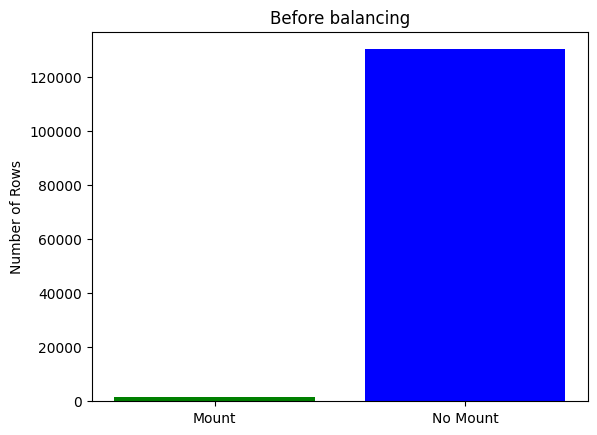

In [41]:
# Vizualization of unbalanced training data 
data['train'] = data_balance(data['train'])

len_mount_after_balanced 218
len_non_mount_after_balanced 218


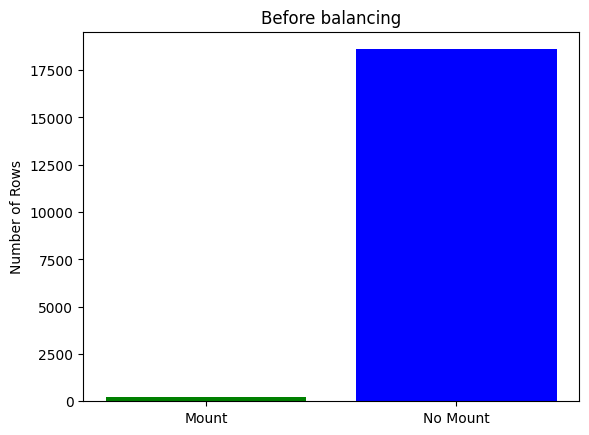

In [42]:
# Vizualization of unbalanced validation data 
data['validation'] = data_balance(data['validation'])

len_mount_after_balanced 448
len_non_mount_after_balanced 448


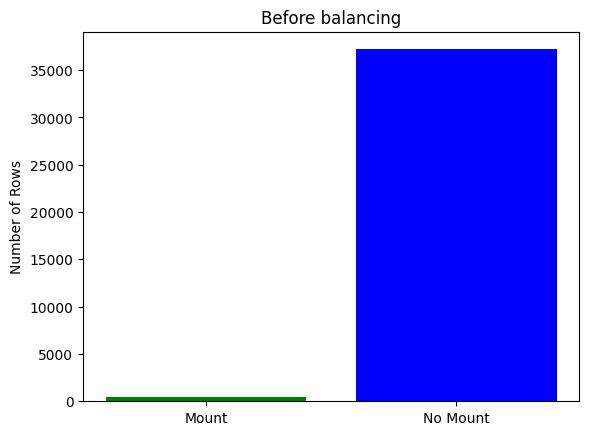

In [43]:
# Vizualization of unbalanced test data 
data['test'] = data_balance(data['test'])

In [44]:
df_train = pd.DataFrame(data['train'])
df_valid = pd.DataFrame(data['validation'])
df_test = pd.DataFrame(data['test'])


In [45]:
# Let's count mountains name,and other words
mark_1 = []
mark_0 = []
for w,p in zip(df_train['fine_ner_tags'].values, df_train['tokens'].values):
    for idx, ww in enumerate(w):
       if ww == 24:
         mark_1.append(p[idx])
       else:
         mark_0.append(p[idx])

In [46]:
# Len of each mark
print(len(mark_1))
print(len(mark_0))

4500
75432


In [47]:
pd.value_counts(mark_1)

Mountains      285
Mount          252
Mountain       144
Range          125
Hill           123
              ... 
aurus            1
Market           1
Mohave           1
Gennargentu      1
Hump             1
Length: 1871, dtype: int64

<Axes: >

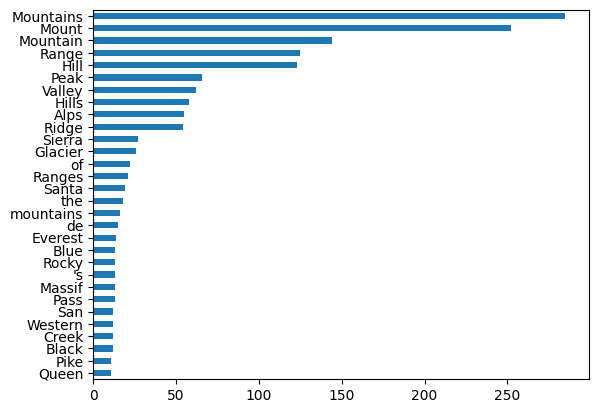

In [48]:
pd.value_counts(mark_1)[:30][::-1].plot(kind='barh')

<Axes: >

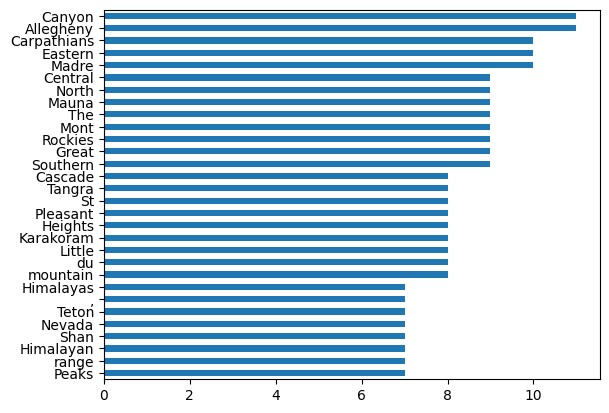

In [49]:
pd.value_counts(mark_1)[30:60][::-1].plot(kind='barh')

As we can see, separate conjunctions and prepositions are also marked with the number 24, they are counted as a separate name of the mountains, not as a part of the name

In [50]:
def clean_text(text):
    text=' '.join([i for i in text.split(',')])
    text=' '.join([i for i in text.split("'")])
    text=' '.join([i for i in text.split() if i.isalpha()])
    
    return text
     

In [51]:
# Convert list of words to string, representing whole sentence
def convert_list_of_words_to_sentance(df):
    df['sentences'] = df['tokens'].apply(lambda x: str(x)[1:-1])
    df['content'] = df['sentences'].apply(clean_text)
    df.head()
    return df

In [52]:
convert_list_of_words_to_sentance(df_train)
convert_list_of_words_to_sentance(df_test)
convert_list_of_words_to_sentance(df_valid)

,id,tokens,ner_tags,fine_ner_tags,sentences,content
0,131,"[It, replaced, the, Ford, 7Y, and, was, a, fac...","[0, 0, 0, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 59, 59, 0, 0, 0, 0, 0, 0, 0, 0, 0]","'It', 'replaced', 'the', 'Ford', '7Y', 'and', ...",It replaced the Ford and was a facelifted vers...
1,13564,"[Joseph, came, to, Mount, Clemens, ,, Michigan...","[7, 0, 0, 4, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0]","[54, 0, 0, 24, 24, 0, 21, 0, 0, 0, 0, 0, 0, 0, 0]","'Joseph', 'came', 'to', 'Mount', 'Clemens', ',...",Joseph came to Mount Clemens Michigan in to pa...
2,17424,"[This, is, the, last, in, a, series, of, peaks...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 24, 24, 0, 0...","'This', 'is', 'the', 'last', 'in', 'a', 'serie...",This is the last in a series of peaks connecte...
3,56,"[``, i, ``, (, 2014, ), was, inspired, by, Sam...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 7, 7, 0]","[0, 6, 0, 0, 0, 0, 0, 0, 0, 54, 54, 0]","'``', 'i', '``', '(', '2014', ')', 'was', 'ins...",i was inspired by Samuel Beckett
4,10267,"[Kitzeck, im, Sausal, lies, between, the, Kora...","[4, 4, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 4, 4, 4, ...","[21, 21, 21, 0, 0, 0, 21, 0, 0, 0, 0, 0, 21, 2...","'Kitzeck', 'im', 'Sausal', 'lies', 'between', ...",Kitzeck im Sausal lies between the Koralpe in ...
...,...,...,...,...,...,...
431,97,"[The, Millers, would, leave, for, New, Hampshi...","[0, 5, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 37, 0, 0, 0, 21, 21, 0, 0, 0, 0, 0, 0, 0, ...","'The', 'Millers', 'would', 'leave', 'for', 'Ne...",The Millers would leave for New Hampshire afte...
432,25,"[Only, two, months, later, ,, Azcue, had, a, f...","[0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 5, 5, 0, 7, ...","[0, 0, 0, 0, 0, 54, 0, 0, 0, 0, 0, 35, 35, 0, ...","'Only', 'two', 'months', 'later', ',', 'Azcue'...",Only two months later Azcue had a falling out ...
433,104,"[In, 1867, ,, the, British, North, America, Ac...","[0, 0, 0, 0, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 4, ...","[0, 0, 0, 0, 47, 47, 47, 47, 0, 0, 0, 0, 0, 0,...","'In', '1867', ',', 'the', 'British', 'North', ...",In the British North America Act was passed by...
434,17750,"[The, highest, point, of, the, island, ,, Mont...","[0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 24, 24, 0, 0, 0, 0, 0, 0...","'The', 'highest', 'point', 'of', 'the', 'islan...",The highest point of the island Monte Epomeo i...


In [53]:
# Data preprocessing for spacy ner
def word_classifier(df):
    data_for_spacy = []
    for i in range(len(df)):
        stri = ' '
        ent = {}
        ent['entities'] = []
        last_item = None
        for word in df.iloc[i]['tokens']:
            stri+=f'{word} '
        for idx, word in zip(df.iloc[i]['fine_ner_tags'], df.iloc[i]['tokens']):
            if (idx == 24 and last_item != 24):
                start_index = stri.find(word)
                end_index = start_index + len(word)
                s = (start_index, end_index, 'B_Mount')
                ent['entities'].append(s)
            if (idx == 24 and last_item == 24):
                start_index = stri.find(word)
                end_index = start_index + len(word)
                s = (start_index, end_index, 'I_Mount')
                ent['entities'].append(s)
            last_item = idx
        ent['entities'] = list(set(ent['entities']))
        res = (stri, ent)
        data_for_spacy.append(res)
        if i == 10:
          break
    pprint(data_for_spacy[:100])
    return data_for_spacy

In [54]:
model = None
output_dir=Path("/save_dir")
n_iter=100

In [55]:
# load model
if model is not None:
    nlp = spacy.load(model)  
    print("Loaded model '%s'" % model)
else:
    nlp = spacy.blank('en')  
    print("Created blank 'en' model")

Created blank 'en' model


In [56]:
if 'ner' not in nlp.pipe_names:
    ner = nlp.add_pipe('ner')
else:
    ner = nlp.get_pipe('ner')

In [57]:
data_for_spacy = word_classifier(df_train)
from spacy.util import minibatch, compounding
for _, annotations in data_for_spacy:
    for ent in annotations.get('entities'):
        ner.add_label(ent[2])

other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
with nlp.disable_pipes(*other_pipes):  # only train NER
    optimizer = nlp.begin_training()
    for itn in range(n_iter):
        random.shuffle(data_for_spacy)
        losses = {}
        for batch in minibatch(data_for_spacy, size=8):
            for text, annotations in batch:
                doc = nlp.make_doc(text)
                example = Example.from_dict(doc, annotations)
                nlp.update(
                [example],   
                drop=0.5,  
                sgd=optimizer,
                losses=losses)
        print(losses)


[(' In addition to the park and town , several places and organizations in '
  'Arizona were named after him : Bill Williams River and Bill Williams '
  'Mountain , the Bill Williams Mountain Men of Williams , Arizona chapter of '
  'the Pioneer Club , and the Chautauqua Program : `` Rendezvous With Old Bill '
  'Williams `` . ',
  {'entities': [(108, 116, 'I_Mount'),
                (103, 107, 'B_Mount'),
                (141, 149, 'I_Mount')]}),
 (' Bush became the first Republican to win the White House without carrying '
  'Oakland County since Benjamin Harrison in 1888 . ',
  {'entities': []}),
 (' Although the game features his name , Tom Clancy had little to no '
  'involvement in the development of any of the Splinter Cell games . ',
  {'entities': []}),
 (' Hooker Glacier is one of several glaciers close to the slopes of Aoraki / '
  'Mount Cook in the Southern Alps of New Zealand . ',
  {'entities': [(73, 74, 'I_Mount'),
                (81, 85, 'I_Mount'),
                (6

In [58]:
df_train.head()

,id,tokens,ner_tags,fine_ner_tags,sentences,content
0,96640,"[In, addition, to, the, park, and, town, ,, se...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 21, 0,...","'In', 'addition', 'to', 'the', 'park', 'and', ...",In addition to the park and town several place...
1,570,"[Bush, became, the, first, Republican, to, win...","[7, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 4, 4, 0, ...","[55, 0, 0, 0, 0, 0, 0, 0, 11, 11, 0, 0, 21, 21...","'Bush', 'became', 'the', 'first', 'Republican'...",Bush became the first Republican to win the Wh...
2,96,"[Although, the, game, features, his, name, ,, ...","[0, 0, 0, 0, 0, 0, 0, 7, 7, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 54, 54, 0, 0, 0, 0, 0, 0...","'Although', 'the', 'game', 'features', 'his', ...",Although the game features his name Tom Clancy...
3,78626,"[Hooker, Glacier, is, one, of, several, glacie...","[4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, ...","[25, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 24, 24,...","'Hooker', 'Glacier', 'is', 'one', 'of', 'sever...",Hooker Glacier is one of several glaciers clos...
4,63822,"[Because, of, its, fame, as, a, monument, ,, M...","[0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 24, 24, 0, 0, 0, 0, 0...","'Because', 'of', 'its', 'fame', 'as', 'a', 'mo...",Because of its fame as a monument Mount Rushmo...


In [59]:
def data_preprocess(df):
    df = df.drop(columns=['id','ner_tags'],axis = 1)
    df['id'] = pd.Series(df.index.values)
    df['id'].shape
    return df

In [60]:
df_train = data_preprocess(df_train)
df_test = data_preprocess(df_test)
df_valid = data_preprocess(df_valid)

In [61]:
df_train

,tokens,fine_ner_tags,sentences,content,id
0,"[In, addition, to, the, park, and, town, ,, se...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 21, 0,...","'In', 'addition', 'to', 'the', 'park', 'and', ...",In addition to the park and town several place...,0
1,"[Bush, became, the, first, Republican, to, win...","[55, 0, 0, 0, 0, 0, 0, 0, 11, 11, 0, 0, 21, 21...","'Bush', 'became', 'the', 'first', 'Republican'...",Bush became the first Republican to win the Wh...,1
2,"[Although, the, game, features, his, name, ,, ...","[0, 0, 0, 0, 0, 0, 0, 54, 54, 0, 0, 0, 0, 0, 0...","'Although', 'the', 'game', 'features', 'his', ...",Although the game features his name Tom Clancy...,2
3,"[Hooker, Glacier, is, one, of, several, glacie...","[25, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 24, 24,...","'Hooker', 'Glacier', 'is', 'one', 'of', 'sever...",Hooker Glacier is one of several glaciers clos...,3
4,"[Because, of, its, fame, as, a, monument, ,, M...","[0, 0, 0, 0, 0, 0, 0, 0, 24, 24, 0, 0, 0, 0, 0...","'Because', 'of', 'its', 'fame', 'as', 'a', 'mo...",Because of its fame as a monument Mount Rushmo...,4
...,...,...,...,...,...
2999,"[The, Klosterbach, emerges, north, of, Bieren,...","[0, 22, 0, 0, 0, 21, 0, 0, 21, 21, 0, 0, 0, 0,...","'The', 'Klosterbach', 'emerges', 'north', 'of'...",The Klosterbach emerges north of Bieren near t...,2999
3000,"[It, continues, by, ascending, over, the, Curl...","[0, 0, 0, 0, 0, 0, 24, 24, 0, 0, 0, 21, 0, 0, ...","'It', 'continues', 'by', 'ascending', 'over', ...",It continues by ascending over the Curlew Moun...,3000
3001,"[The, National, Historic, Oregon, Trail, Inter...","[0, 11, 11, 11, 11, 11, 11, 0, 0, 0, 0, 0, 0, ...","'The', 'National', 'Historic', 'Oregon', 'Trai...",The National Historic Oregon Trail Interpretiv...,3001
3002,"[The, Alpine, Trail, traverses, the, site, of,...","[0, 27, 27, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 24, ...","'The', 'Alpine', 'Trail', 'traverses', 'the', ...",The Alpine Trail traverses the site of a plane...,3002


Data labeling and feature simplification

In [62]:
def classifire_tags(df):
    tag =[]
    for t in range(len(df)):
        last_item = None
        for idx in df.iloc[t]['fine_ner_tags']:
            if idx == 24:
                if last_item == 24:
                    tag.append('I_Mount')
                else:
                    tag.append('B_Mount')
            else:
                tag.append('O')
            last_item = idx
    print(tag)
    return tag


In [63]:
def row_wise(df):
    da = pd.DataFrame()
    k = 0
    for i in zip(df['fine_ner_tags'][:1], df['tokens'][:1]):
      data = pd.DataFrame(np.vstack(i[0]), np.vstack(i[1]))
      data.columns=['tags']
      data['id'] = k
      k +=1
      data = data.reset_index()
      da = data
      break
  
    for i in zip(df['fine_ner_tags'][1:], df['tokens'][1:]):
      data = pd.DataFrame(np.vstack(i[0]), np.vstack(i[1]))
      data.columns=['tags']
      data['id'] = k
      k +=1
      data = data.reset_index()
      da = pd.concat([da,data], axis=0)
    da['index'] = da['index'].apply(lambda x: x[0])
    da['tags']=classifire_tags(df)
    return da

In [64]:
da_train = row_wise(df_train)
da_test = row_wise(df_test)
da_valid = row_wise(df_valid)

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B_Mount', 'I_Mount', 'I_Mount', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B_Mount', 'I_Mount', 'I_Mount', 'I_Mount', 'O', 'O', 'O', 'B_Mount', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B_Mount', 'I_Mount', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',

In [65]:
da_train.head()

,index,tags,id
0,In,O,0
1,addition,O,0
2,to,O,0
3,the,O,0
4,park,O,0


In [66]:
def rename_columns(df):
    df.head(200)
    df.tags.unique()
    df.rename(columns={"index":"words","tags":"labels","id":"sentence_id"}, inplace =True)
    return df

In [67]:
da_train = rename_columns(da_train)
da_test = rename_columns(da_test)
da_valid = rename_columns(da_valid)

In [68]:
da_test.head()

,words,labels,sentence_id
0,The,O,0
1,main,O,0
2,event,O,0
3,of,O,0
4,the,O,0


In [69]:
train_data = pd.DataFrame({"sentence_id":da_train["sentence_id"],"words":da_train["words"],"labels":da_train["labels"]})
test_data = pd.DataFrame({"sentence_id":da_test["sentence_id"],"words":da_test["words"],"labels":da_test["labels"]})

In [70]:
valid_data = pd.DataFrame({"sentence_id":da_valid["sentence_id"],"words":da_valid["words"],"labels":da_valid["labels"]})
train_data.labels = train_data['labels'].apply(lambda x: str(x))
test_data.labels = test_data['labels'].apply(lambda x: str(x))

In [71]:
label = train_data["labels"].unique().tolist()
label

['O', 'B_Mount', 'I_Mount']

In [72]:
args = NERArgs()
args.num_train_epochs = 20
args.learning_rate = 1e-4
args.overwrite_output_dir =True
args.train_batch_size = 64
args.eval_batch_size = 64

In [73]:
model = NERModel('bert', 'bert-base-cased', labels=label, args=args, use_cuda= False)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [74]:
model.train_model(train_data, eval_data=valid_data,acc=accuracy_score)

C:\Users\dzyub\anaconda3\lib\site-packages\simpletransformers\ner\ner_utils.py:190: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  return [


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Running Epoch 0 of 20:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 1 of 20:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 2 of 20:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 3 of 20:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 4 of 20:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 5 of 20:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 6 of 20:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 7 of 20:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 8 of 20:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 9 of 20:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 10 of 20:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 11 of 20:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 12 of 20:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 13 of 20:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 14 of 20:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 15 of 20:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 16 of 20:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 17 of 20:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 18 of 20:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 19 of 20:   0%|          | 0/47 [00:00<?, ?it/s]

(940, 0.025315867360590577)

In [75]:
result, model_outputs, preds_list = model.eval_model(test_data)

C:\Users\dzyub\anaconda3\lib\site-packages\simpletransformers\ner\ner_utils.py:190: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  return [


  0%|          | 0/2 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/14 [00:00<?, ?it/s]

C:\Users\dzyub\anaconda3\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: B_Mount seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
C:\Users\dzyub\anaconda3\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: I_Mount seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


In [76]:
prediction, model_output = model.predict(["I visited the Everest Mountains when I was a child."])

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

In [77]:
print(prediction)

[[{'I': 'O'}, {'visited': 'O'}, {'the': 'O'}, {'Everest': 'B_Mount'}, {'Mountains': 'I_Mount'}, {'when': 'O'}, {'I': 'O'}, {'was': 'O'}, {'a': 'O'}, {'child.': 'O'}]]


In [78]:
prediction, model_output = model.predict(["Mount Avalanche is the highest in Kaiserstuhl."])

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

In [79]:
print(prediction)

[[{'Mount': 'B_Mount'}, {'Avalanche': 'I_Mount'}, {'is': 'O'}, {'the': 'O'}, {'highest': 'O'}, {'in': 'O'}, {'Kaiserstuhl.': 'B_Mount'}]]


In [80]:
prediction, model_output = model.predict(["Karakoram,Tangra and Manua are the bigest mountain in Asia."])

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

In [81]:
print(prediction)

[[{'Karakoram,Tangra': 'B_Mount'}, {'and': 'O'}, {'Manua': 'B_Mount'}, {'are': 'O'}, {'the': 'O'}, {'bigest': 'O'}, {'mountain': 'O'}, {'in': 'O'}, {'Asia.': 'O'}]]


In [82]:
prediction, model_output = model.predict(["There are wonderful view on Annapurna Dakshin on Hymalayas."])

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

In [83]:
print(prediction)

[[{'There': 'O'}, {'are': 'O'}, {'wonderful': 'O'}, {'view': 'O'}, {'on': 'O'}, {'Annapurna': 'O'}, {'Dakshin': 'O'}, {'on': 'O'}, {'Hymalayas.': 'B_Mount'}]]
